## Ejemplo de boosting para clasificación

In [ ]:
%autosave 0
import pandas as pd
import numpy as np
from plotnine import *
import xgboost as xgb

### Datos

Usaremos los datos de seguros para hacer experimentos con boosting

In [36]:
# preprocesar
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
caravan = pd.read_csv('../datos/caravan-insurance-challenge.csv')
columnas = caravan.columns[2:86]
print(columnas)
def preprocesar_caravan(datos, tipo, columnas):
    # filtrar tipo
    datos_p = datos[datos["ORIGIN"] == tipo].copy()
    # variable respuesta
    y = datos_p["CARAVAN"].values
    datos_p = datos_p[columnas]
    datos_tipo = pd.get_dummies(datos_p.MOSHOOFD, prefix="MOSHOODFD_", drop_first = True)
    datos_p = datos_p.drop(columns = ["MOSHOOFD"])
    datos_p = pd.concat([datos_tipo, datos_p], axis = 1, sort=False)
    columnas_x = datos_p.columns
    #datos_origen = datos[datos["ORIGIN"] == tipo].drop(columns = ["ORIGIN"])
    X = datos_p.values
    return X, y, columnas_x
X_ent, y_ent, columnas_x = preprocesar_caravan(caravan, "train", columnas)
X_pr, y_pr, _ = preprocesar_caravan(caravan, "test", columnas)
print(X_ent.shape)
np.unique(y_ent, return_counts=True)

Index(['MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK', 'MGODPR',
       'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN',
       'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG',
       'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA',
       'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2',
       'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575',
       'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART', 'PWABEDR',
       'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG',
       'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG',
       'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED',
       'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT',
       'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM',
       'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL',
       'APLEZIER', 'AFIETS', 'AINBOED',

(array([0, 1]), array([5474,  348]))

### Modelo
En esta parte experimenta con distintos parámetros para mejorar el desempeño. Antes de hacer un experimento, pregúntate por qué razón intentarías hacer cada cambio. En este caso seleccionamos modelos con validación cruzada:

In [26]:
d_entrena = xgb.DMatrix(X_ent, label=y_ent, feature_names = columnas_x)
# nótese que usamos devianza como pérdida
param = {'max_depth': 4, 'eta': 0.3, 'lambda': 0, 'subsample':1.0, 'objective': 'binary:logistic',
  'nthread': 5}
num_rounds = 100
res = xgb.cv(param, d_entrena, num_rounds, nfold=10,
       seed=10, 
       #metrics={'auc', 'logloss'},
       metrics = 'logloss',
       callbacks=[xgb.callback.print_evaluation(show_stdv=True, period = 50)])

[0]	train-logloss:0.489329+0.000979401	test-logloss:0.49171+0.00434997
[50]	train-logloss:0.129603+0.00196696	test-logloss:0.213145+0.0244972
[99]	train-logloss:0.0968787+0.0022132	test-logloss:0.233681+0.0294583


Después de experimentar, haz predicciones y evalúa en el conjunto de entrenamiento

In [27]:
modelo = xgb.train(param, d_entrena, num_rounds)

In [28]:
d_prueba = xgb.DMatrix(X_pr, feature_names = columnas_x)
probas_pr = modelo.predict(d_prueba)
#Nos da probabilidades
probas_pr

array([0.00263204, 0.5514935 , 0.05783116, ..., 0.13132633, 0.10402745,
       0.01042803], dtype=float32)

AUC prueba: 0.703
log pérdida prueba: 0.235


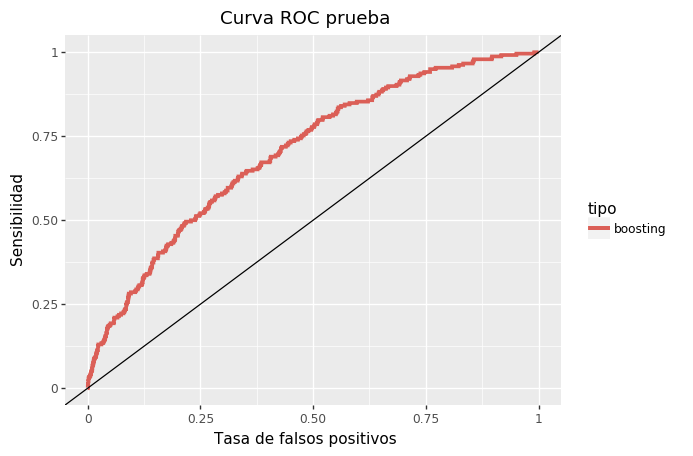

<ggplot: (8733521315795)>

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
# Curva ROC y AUC
tfp, tvp, cortes = roc_curve(y_pr, probas_pr)
datos_roc = pd.DataFrame({"tfp":tfp, "tvp":tvp, "corte":cortes})
datos_roc["tipo"] = "boosting"
print("AUC prueba:", roc_auc_score(y_pr, probas_pr).round(3))
print("Log pérdida prueba:", log_loss(y_pr, probas_pr).round(3))

(ggplot(datos_roc, aes("tfp", "tvp", group="tipo", colour="tipo")) 
  + geom_step(size=1.5)
  + geom_abline(slope=1, intercept=0)
  + xlab("Tasa de falsos positivos") + ylab("Sensibilidad")
  + labs(title ="Curva ROC prueba"))


### Importancia de variables
Aunque podemos calcular importancia por permutaciones, xgboost provee un método, que cuenta
cuántas veces aparece cada variable en los árboles

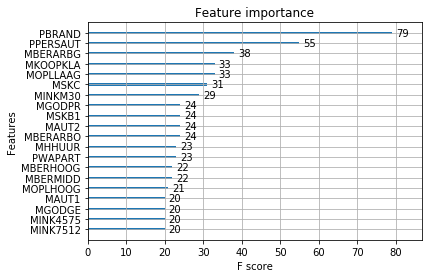

In [33]:
xgb.plot_importance(modelo, max_num_features = 20)